# Predicting Subscription of Game-Related Newsletter using Classification

## (1) Introduction

The data was collected by a research group at UBC in Computer Science, led by Frank Wood (Pacific Laboratory for Artificial Intelligence (PLAI), 2023). They set up a MineCraft server that links to an external site and recorded the players' actions as they navigated through the world.  

The datasets are not in a tidy format. The "end_time" and "start_time" has to be separated into two columns in sessions.csv: date and time. There are missing values in the age column of players.csv, so they should be removed. 

### Question 
Can the player age and hours played in MineCraft predict whether players are subscribed to a game-related newsletter? 

### Players Dataset
Overview
- Number of observations (rows): 196
- Number of variables (columns): 7
- played_hours might be from the Minecraft server, but all other data was most likely from their website where players enter their information

| Variable Name | Type | Description | Summary Statistics (to 2 decimals) | Notes / Issues |
| - | - | - | - | - |
| `experience` | Categorical | Player’s self-reported experience level (e.g., Amateur, Intermediate, Expert, etc.) | 5 unique values; most common: *Amateur* (63 players) | Could be ordinal but stored as text. |
| `subscribe` | Categorical | Whether the player subscribed to a game-related newsletter | 144 (True), 52 (False) | Fairly imbalanced — may bias models. |
| `hashedEmail` | String | Unique player identifier (hashed for privacy) | 196 unique values | Good for joining with `sessions.csv`. |
| `played_hours` | Numeric | Total number of hours each player spent in-game | Mean = 5.85, SD = 28.36, Min = 0.00, Median = 0.10, Max = 223.10 | Highly skewed — some extreme outliers. |
| `name` | String | Player’s name (pseudonymized) | 196 unique values | Not useful analytically. |
| `gender` | Categorical | Self-reported gender (Male, Female, Nonbinary, etc.) | 7 unique categories; most common: *Male* (124 players) | Possible inconsistencies or typos in text. |
| `Age` | Numeric | Player’s age in years | Mean = 21.14, SD = 7.39, Min = 9.00, Median = 19.00, Max = 58.00 | 2 missing values; wide age range. |

### Sessions Dataset
Overview
- Number of observations (rows): 1,535
- Number of variables (columns): 5
- Data was collected from the Minecraft server.

| Variable Name | Type | Description | Summary Statistics (to 2 decimals) | Notes / Issues |
| - | - | - | - | - |
| `hashedEmail` | String | Unique identifier matching players in `players.csv` | 125 unique IDs; most common appears 310 times | Used to link sessions to players. |
| `start_time` | String | Start timestamp of a game session (formatted date-time string) | 1,504 unique; most common = “28/06/2024 01:31” | Needs conversion to datetime. |
| `end_time` | String | End timestamp of a game session | 1,489 unique; 2 missing values | Needs conversion to datetime; missing values cause incomplete sessions. |
| `original_start_time` | Numeric | Original Unix timestamp of session start | Mean = 1.72×10¹², SD = 3.56×10⁹ | Likely milliseconds since epoch; can be converted to readable dates. |
| `original_end_time` | Numeric | Original Unix timestamp of session end | Mean = 1.72×10¹², SD = 3.55×10⁹ | 2 missing values; aligns with `end_time`. |


## (2) Methods and Results

### Load libraries and datset

In [7]:
# include libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(ggplot2)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [8]:
# load both datasets
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
players
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [9]:
# select variables that will be used and filter out rows that have missing values
players_tidy <- players |>
  select(subscribe, played_hours, Age) |>
  filter(!is.na(Age)) |>
  mutate(subscribe = factor(subscribe, levels = c(FALSE, TRUE), labels = c("No", "Yes")))
players_tidy

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
Yes,30.3,9
Yes,3.8,17
No,0.0,17
⋮,⋮,⋮
No,0.3,22
No,0.0,57
No,2.3,17


### Summary of Variables
| Variable Name | Mean | Max | Min|
| - | - | - | - |
| played_hours | 5.85 | 223.10 | 0.00 |
| Age | 21.14 | 58.00 | 9.00 |

### Create a scatterplot of players_tidy to visualise data

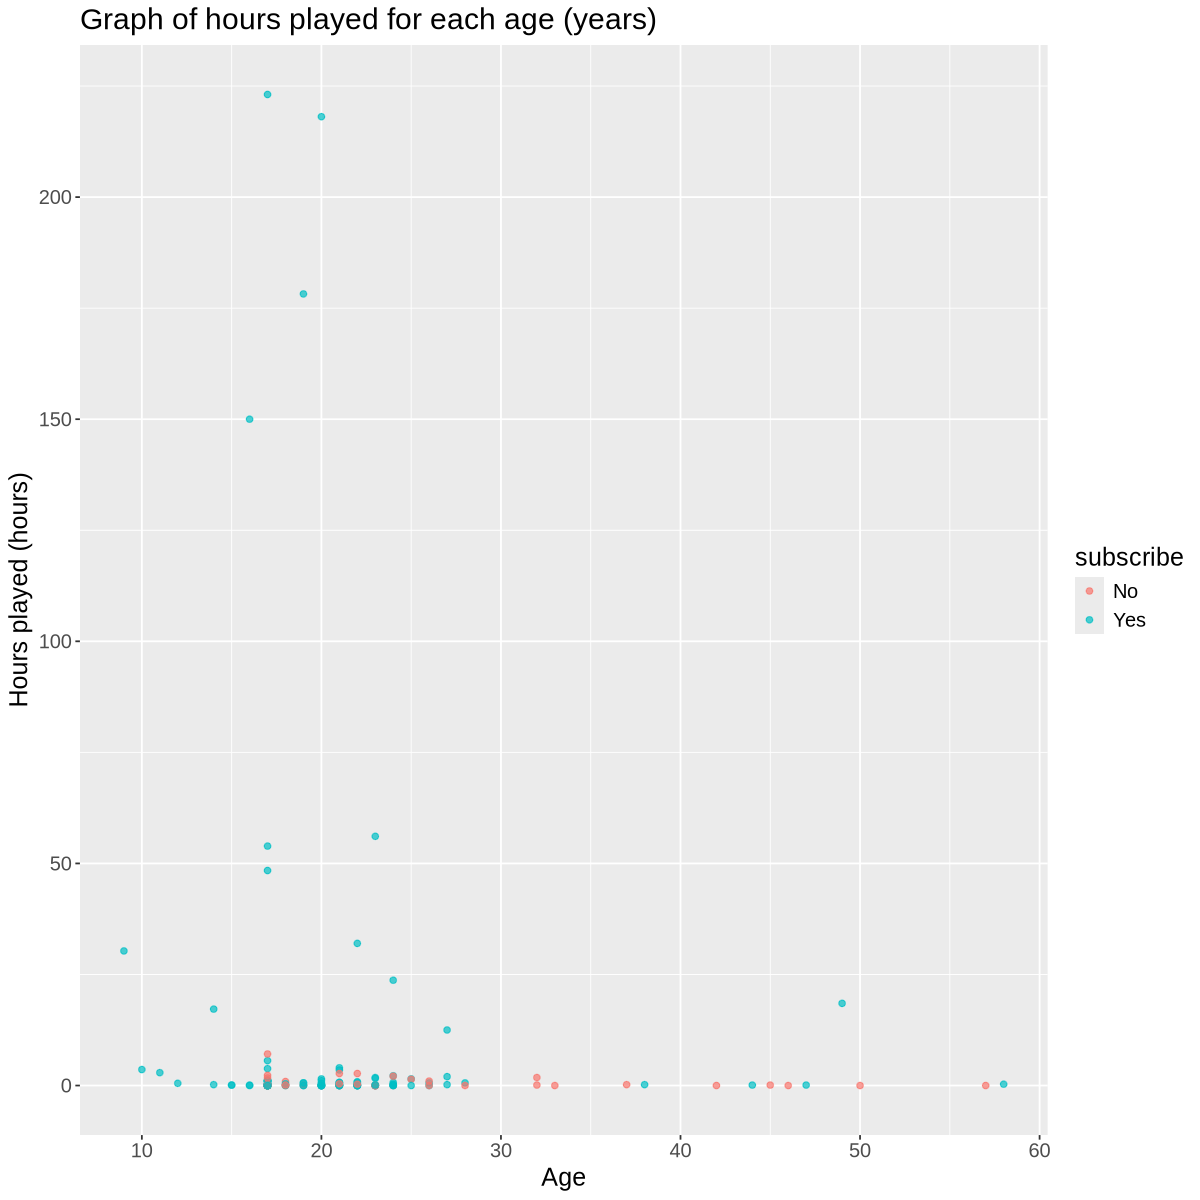

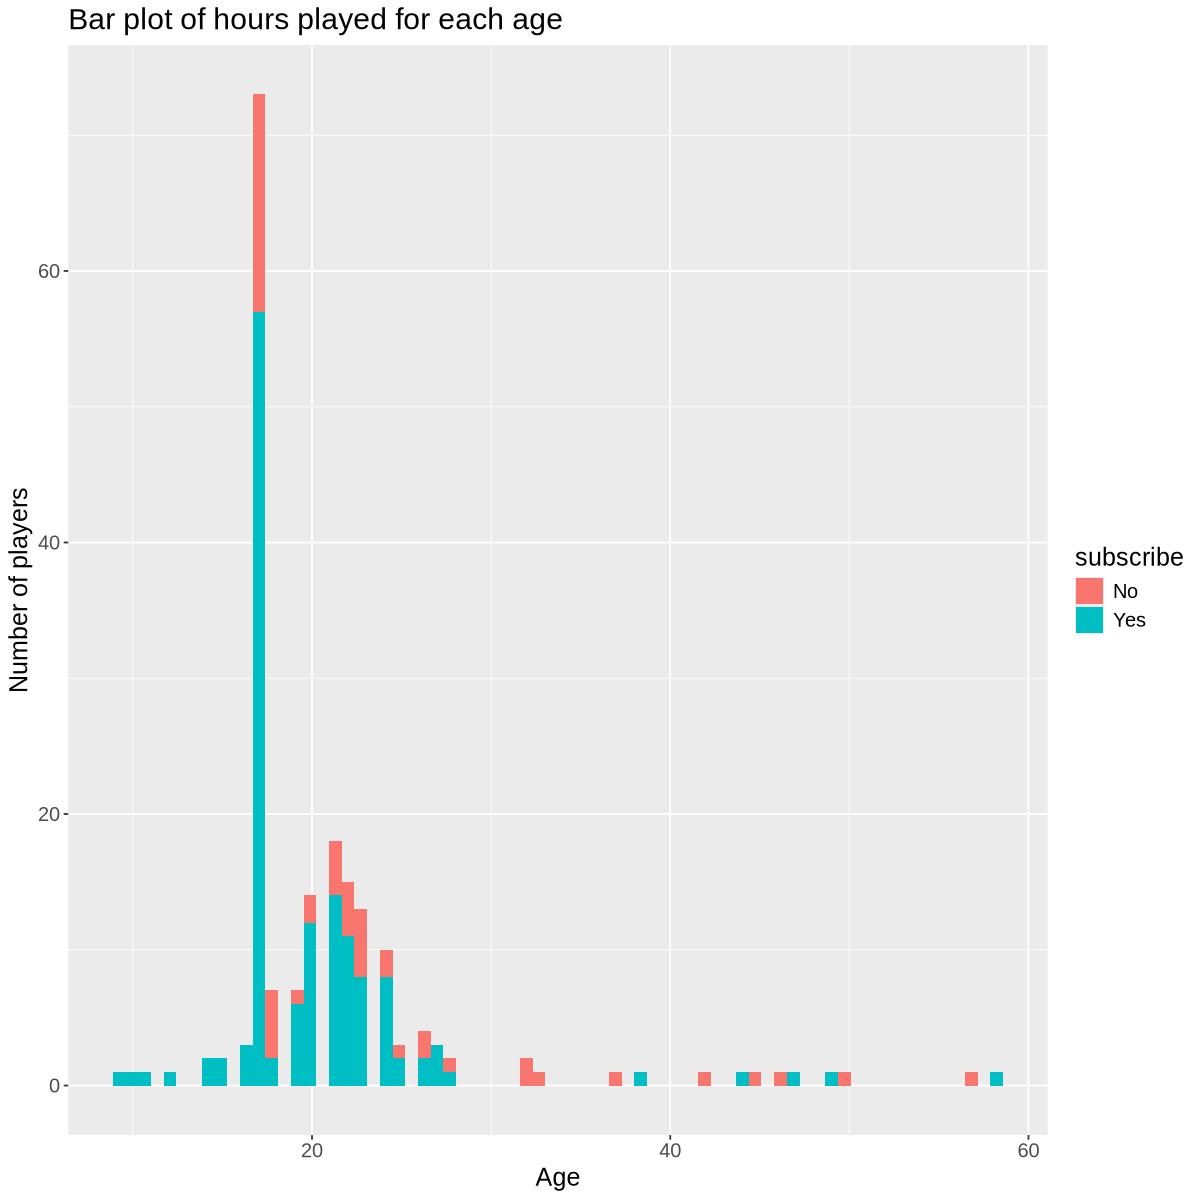

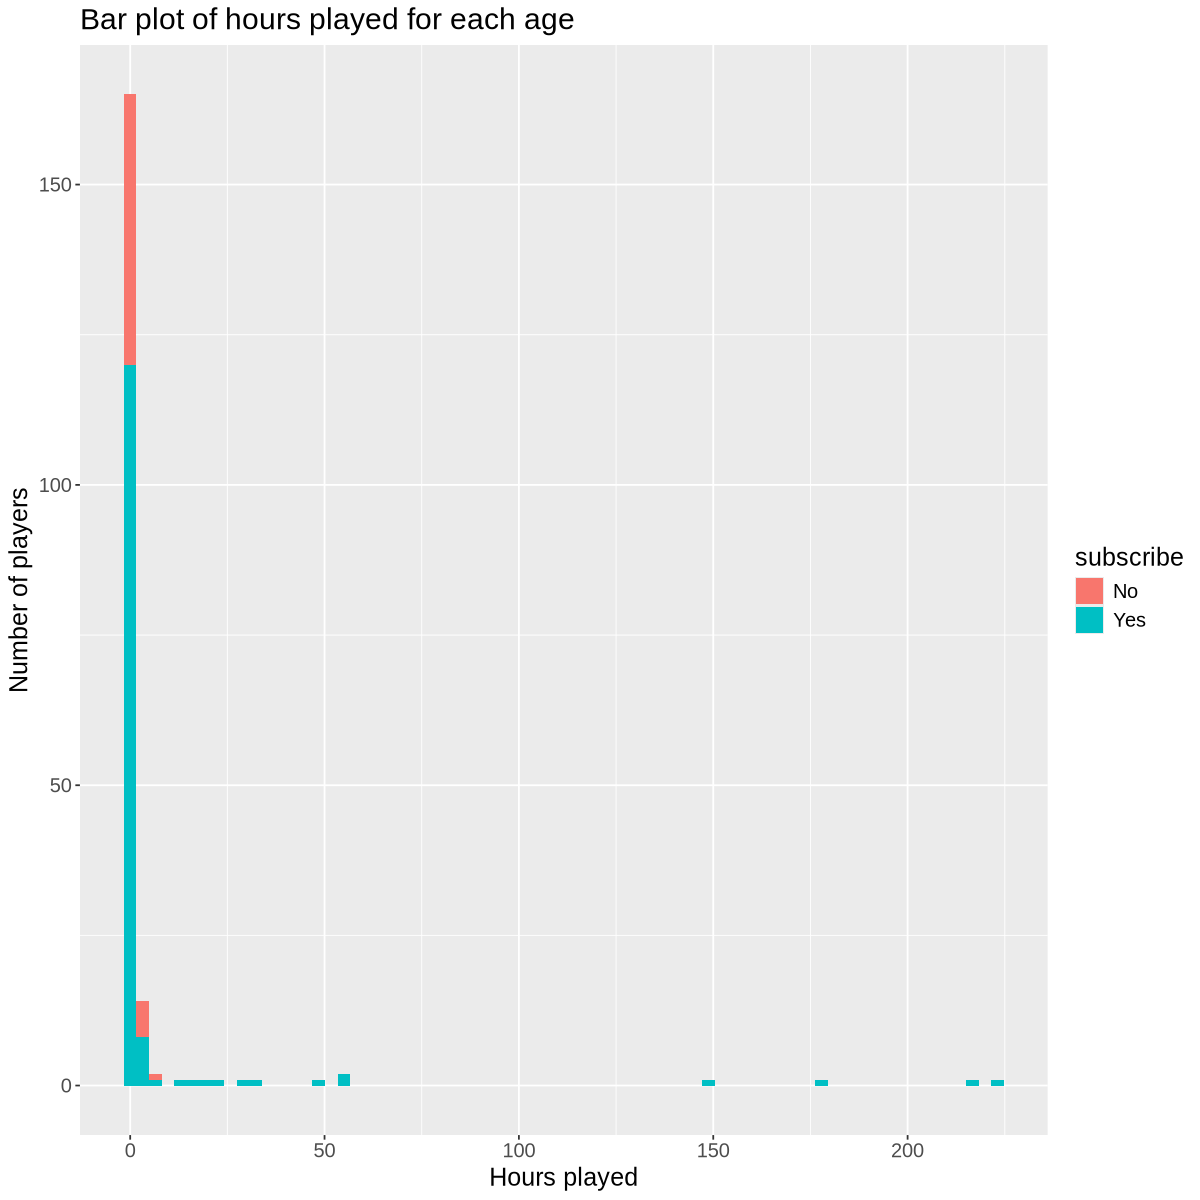

In [10]:
options(repr.plot.width = 10, repr.plot.height = 10) 
subscribe_bar_1 <- players_tidy |>
ggplot(aes(x = Age, fill = subscribe)) +
geom_histogram(bins=70) +
labs(x="Age",
y = "Number of players",
title="Bar plot of hours played for each age") +
theme(text = element_text(size=15)) 

subscribe_bar_2 <- players_tidy |>
ggplot(aes(x = played_hours, fill = subscribe)) +
geom_histogram(bins=70) +
labs(x="Hours played",
y = "Number of players",
title="Bar plot of hours played for each age") +
theme(text = element_text(size=15)) 

subscribe_plot <- players_tidy |>
ggplot(aes(x = Age, y = played_hours, colour = subscribe)) +
geom_point(alpha = 0.7) +
labs(x="Age",
y = "Hours played (hours)",
title="Graph of hours played for each age (years)") +
theme(text = element_text(size=15))

subscribe_plot
subscribe_bar_1
subscribe_bar_2

In [11]:
#set.seed to 1234
set.seed(1234) 
 
#split the dataset in training and testing sets
players_split <- initial_split(players_tidy, prop = 0.7, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#split training set into subtrain and validation set 
players_split_cross <- initial_split(players_train, prop = 0.7, strata = subscribe)
players_subtrain <- training(players_split_cross)
players_validation <- testing(players_split_cross)

#set folds for cross-validation
players_vfold <- vfold_cv(players_subtrain, v = 5, strata = subscribe)

#create recipe
players_recipe <- recipe(subscribe ~ .,
                        data = players_subtrain) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#create specification
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#create tibble of K values
k_values <- tibble(neighbors = seq(from=1, to=20, by=1))

#create workflow
players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_values) |>
  collect_metrics()

#calculate for accuracy
players_accuracies <- players_results |>
  filter(.metric == "accuracy")

#plot accuracy vs K
cross_val_players_plot <- ggplot(players_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

cross_val_players_plot

ERROR: Error in eval(expr, envir, enclos): object 'players_results' not found


In [12]:
#create new recipe
players_recipe_2 <- recipe(subscribe ~ .,
                        data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#create a new spec with K = 12
players_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
  set_engine("kknn") |>
  set_mode("classification")

#create workflow
players_fit_2 <- workflow() |>
  add_recipe(players_recipe_2) |>
  add_model(players_spec_2) |>
  fit(data = players_train)

#predict on the testing data
players_predict <- predict(players_fit_2, players_test) |>
bind_cols(players_test)

#find accuracy of the classifier model
players_test_accuracies <- players_predict|>
metrics(truth = subscribe, estimate = .pred_class) |>
filter(.metric == "accuracy")

players_fit_2
players_test_accuracies

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(12,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2740741
Best kernel: rectangular
Best k: 12

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6440678


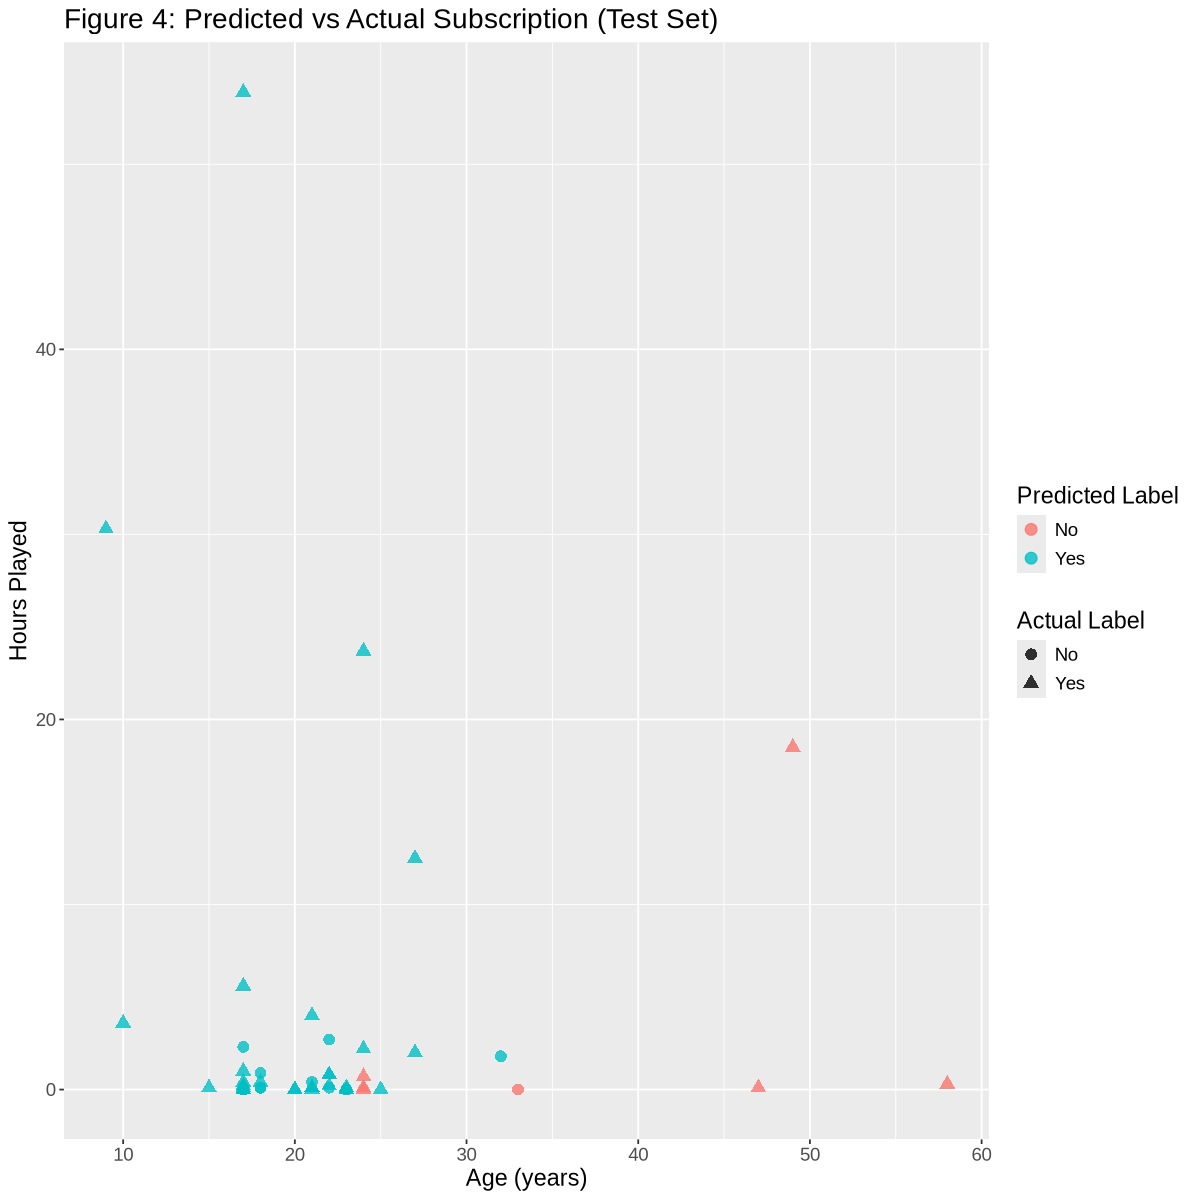

In [14]:
# create a tibble comparing actual vs predicted
players_test_plot <- players_test |>
  select(Age, played_hours, subscribe) |>
  mutate(predicted = players_predict$.pred_class)

# scatterplot: Age vs Hours, colored by predicted label, shape by actual label
figure4_plot <- ggplot(players_test_plot, aes(x = Age, y = played_hours)) +
  geom_point(aes(color = predicted, shape = subscribe), size = 3, alpha = 0.8) +
  labs(
    title = "Figure 4: Predicted vs Actual Subscription (Test Set)",
    x = "Age (years)",
    y = "Hours Played",
    color = "Predicted Label",
    shape = "Actual Label"
  ) +
  theme(text = element_text(size = 14))

figure4_plot

## (3) Discussion

## (4) References

Pacific Laboratory for Artificial Intelligence (PLAI). (2023, September 28). Home Page - Pacific Laboratory for Artificial Intelligence. Pacific Laboratory for Artificial Intelligence. https://plai.cs.ubc.ca/